In [1]:
# path setting
EXP_NAME = "e027-add-word-cnt"
MODEL_NAME = "microsoft/deberta-v3-xsmall"
COMPETITION_NAME = "atmacup17"

DATA_PATH = "data"
ENV_PATH = "env_file"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"
TARGET_COL = "Recommended IND"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
# UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 512
INFERENCE_MAX_LENGTH = 512
SEED = 42
EPOCH = 4
LR = 2e-04
TRAIN_BS = 8
GRAD_ACC_STEP = 128 // TRAIN_BS  # 仮想的なバッチサイズはTRAIN_BS * GRAD_ACC_STEPとなる
EVAL_BS = 8
NUM_LABELS = 2

USE_FOLD = 0  # Fold数は3(0, 1, 2)

In [2]:
!nvidia-smi

Fri Aug 30 08:21:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             39W /  300W |    1811MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!python --version

Python 3.10.14


In [4]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return "kernel", f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return "nohup", f"../../{base_path}"
    elif cwd == f"/content":
        print("Google Colab!")
        return "colab", f"/content/drive/MyDrive/Kaggle/{COMPETITION_NAME}/{base_path}"
    elif cwd.startswith("/home/shinichiro.saito"):
        print("GCP!")
        return "GCP", f"/home/shinichiro.saito/{COMPETITION_NAME}/{base_path}"
    else:
        raise Exception("Unknown environment")


ENV_NAME, DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
_, MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)
_, ENV_PATH = resolve_path(ENV_PATH)

/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/data
/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/trained_models/e027-add-word-cnt
/home/shinichiro.saito/atmacup17/exp
GCP!


In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [6]:
if ENV_NAME != "GCP":
    %pip install -qq polars==1.0.0
    %pip install -qq transformers==4.42.3
    %pip install -qq sentencepiece==0.2.0
    %pip install -qq datasets==2.20.0
    %pip install -qq evaluate==0.4.2
    %pip install -qq seqeval==1.2.2
    %pip install -qq accelerate==0.32.0
    %pip install -qq python-dotenv==1.0.1
    %pip install -qq wandb==0.17.4
    %pip install -qq bitsandbytes==0.43.1
    %pip install -qq accelerate==0.32.0
    %pip install -qq peft==0.11.1

    # formatter
    %pip install -qq black isort

    %pip install -qq kaggle

# import

In [7]:
import os
import random
import ast
import json

import polars as pl
import numpy as np
import torch
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import wandb
from datasets import (
    Dataset,
    DatasetDict,
    Value,
    concatenate_datasets,
    load_dataset,
    ClassLabel,
)
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
from tqdm.auto import tqdm
from scipy.special import softmax
from sklearn.metrics import log_loss
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    DebertaV2PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.deberta_v2.modeling_deberta_v2 import (
    ContextPooler,
    StableDropout,
    DebertaV2Model,
)

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()
NUM_PROC

8

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.42.3"
assert datasets.__version__ == "2.20.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{ENV_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project=COMPETITION_NAME, name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sinchir0. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/shinichiro.saito/.netrc


'wandb'

# Data Import & Preprocess

In [13]:
with open(f"{DATA_PATH}/rec_stratified_fold.json") as f:
    label_stratified_fold = json.load(f)

In [14]:
train = (
    pl.read_csv(f"{DATA_PATH}/train_with_index.csv")
    .join(pl.read_csv(f"{DATA_PATH}/clothing_master.csv"), on="Clothing ID", how="left")
    .with_columns(
        pl.col("Title").fill_null(""),
        pl.col("Review Text").fill_null(""),
    )
    .with_columns(
        pl.col("Title").str.len_chars().alias("title_len"),
        pl.col("Review Text").str.len_chars().alias("review_len"),
    )
    .with_columns(pl.col("Rating") - 1)
    .rename({TARGET_COL: "label"})
    .with_columns(  # foldを追加する
        pl.col("index").replace(label_stratified_fold).alias("fold")
    )
)

test = (
    pl.read_csv(f"{DATA_PATH}/test.csv")
    .join(pl.read_csv(f"{DATA_PATH}/clothing_master.csv"), on="Clothing ID", how="left")
    .with_columns(
        pl.col("Title").fill_null(""),
        pl.col("Review Text").fill_null(""),
    )
    .with_columns(
        pl.col("Title").str.len_chars().alias("title_len"),
        pl.col("Review Text").str.len_chars().alias("review_len"),
    )
)

In [15]:
if DEBUG:
    train = train.head(100)
    test = test.head(100)

In [16]:
train_dataset = Dataset.from_polars(train)
test_dataset = Dataset.from_polars(test)

In [17]:
# https://dev.classmethod.jp/articles/huggingface-usage-custom-model/
# https://github.com/huggingface/transformers/blob/94b3f544a1f5e04b78d87a2ae32a7ac252e22e31/src/transformers/models/deberta_v2/modeling_deberta_v2.py#L1313
from typing import Optional, Union, Tuple
import torch.nn as nn


class CustomDebertaSequenceClassification(DebertaV2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        num_labels = getattr(config, "num_labels", 2)
        self.num_labels = num_labels
        self.rating_labels = 5

        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim

        self.classifier = nn.Linear(output_dim, num_labels)
        self.rating_classifier = nn.Linear(output_dim, self.rating_labels)
        drop_out = getattr(config, "cls_dropout", None)
        drop_out = self.config.hidden_dropout_prob if drop_out is None else drop_out
        self.dropout = StableDropout(drop_out)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.deberta.get_input_embeddings()

    def set_input_embeddings(self, new_embeddings):
        self.deberta.set_input_embeddings(new_embeddings)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        rating: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.deberta(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        pooled_output = self.dropout(pooled_output)
        # Rec
        logits = self.classifier(pooled_output)
        # Rating
        logits_rating = self.rating_classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    # regression task
                    loss_fn = nn.MSELoss()
                    logits = logits.view(-1).to(labels.dtype)
                    loss = loss_fn(logits, labels.view(-1))
                elif labels.dim() == 1 or labels.size(-1) == 1:
                    label_index = (labels >= 0).nonzero()
                    labels = labels.long()
                    if label_index.size(0) > 0:
                        labeled_logits = torch.gather(
                            logits,
                            0,
                            label_index.expand(label_index.size(0), logits.size(1)),
                        )
                        labels = torch.gather(labels, 0, label_index.view(-1))
                        loss_fct = CrossEntropyLoss()
                        loss = loss_fct(
                            labeled_logits.view(-1, self.num_labels).float(),
                            labels.view(-1),
                        )
                    else:
                        loss = torch.tensor(0).to(logits)
                else:
                    log_softmax = nn.LogSoftmax(-1)
                    loss = -((log_softmax(logits) * labels).sum(-1)).mean()
            elif self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        # add
        loss_fct_rating = CrossEntropyLoss()
        loss_rating = loss_fct_rating(
            logits_rating.view(-1, self.rating_labels), rating.view(-1)
        )
        loss += loss_rating

        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [18]:
import random


class CustomDataCollator:
    def __init__(self, tokenizer):
        self.data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=16)

    def __call__(self, features):
        batch = [
            {
                "input_ids": f["input_ids"],
                "token_type_ids": f["token_type_ids"],
                "attention_mask": f["attention_mask"],
            }
            for f in features
        ]

        batch = self.data_collator(batch)

        labels = torch.tensor(
            [
                f["labels"] if f["labels"] is not None else random.choice([0, 1])
                for f in features
            ]
        )
        rating = torch.tensor(
            [
                f["rating"]
                if f["rating"] is not None
                else random.choice([0, 1, 2, 3, 4])
                for f in features
            ]
        )

        return {
            "input_ids": batch["input_ids"],
            "token_type_ids": batch["token_type_ids"],
            "attention_mask": batch["attention_mask"],
            "labels": labels,
            "rating": rating,
        }

In [19]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        item = self.dataset[idx]

        input_ids = torch.tensor(item["input_ids"])
        token_type_ids = torch.tensor(item["token_type_ids"])
        attention_mask = torch.tensor(item["attention_mask"])

        if "label" in item:
            label = torch.tensor(item["label"])
            rating = torch.tensor(item["Rating"])
        else:
            label = None
            rating = None

        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "attention_mask": attention_mask,
            "labels": label,
            "rating": rating,
        }

    def __len__(self):
        return len(self.dataset)

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])

# model = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_NAME, num_labels=NUM_LABELS
# )
model = CustomDebertaSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS, problem_type="single_label_classification"
)
model.resize_token_embeddings(len(tokenizer))

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)
data_collator = CustomDataCollator(tokenizer)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of CustomDebertaSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight', 'rating_classifier.bias', 'rating_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenize

In [21]:
# def tokenize(examples, max_token_length: int):
#     separator = " [SEP] "

#     joined_text = examples["Title"] + separator + examples["Review Text"]

#     return tokenizer(
#         joined_text,
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


# def tokenize(examples, max_token_length: int):
#     return tokenizer(
#         examples["Title"],
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


# def tokenize(examples, max_token_length: int):
#     return tokenizer(
#         examples["Review Text"],
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


def use_all_info(examples) -> str:
    separator = " [SEP] "
    return (
        "Review Text "
        + examples["Review Text"]
        + separator
        + "Title "
        + examples["Title"]
        + separator
        + "Positive Feedback Count "
        + str(examples["Positive Feedback Count"])
        + separator
        + "Age "
        + str(examples["Age"])
        + separator
        + "Division Name "
        + examples["Division Name"]
        + separator
        + "Department Name "
        + examples["Department Name"]
        + separator
        + "Class Name "
        + examples["Class Name"]
        + "Title len "
        + str(examples["title_len"])
        + separator
        + "Review len "
        + str(examples["review_len"])
    )


def tokenize(examples, max_token_length: int):
    text = use_all_info(examples)

    return tokenizer(
        text,
        max_length=max_token_length,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC,
)

test_dataset = test_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/11155 [00:00<?, ? examples/s]

In [22]:
print(tokenizer.decode(train_dataset[0]["input_ids"]))

[CLS] Review Text Adorable, well-made skirt! lined and very slimming. i had to size up b/c it runs a bit snug around the waist. however, it's worth it b/c this will match many long and short sleeve tops![SEP] Title 3-season skirt![SEP] Positive Feedback Count 4[SEP] Age 25[SEP] Division Name General[SEP] Department Name Bottoms[SEP] Class Name SkirtsTitle len 15[SEP] Review len 185[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

In [23]:
print(tokenizer.decode(test_dataset[0]["input_ids"]))

[CLS] Review Text I love this skirt. it does run a little small, i ordered an extra small and it is tight at the waist, but still works. i have received more compliments on this skirt than maybe anything i have owned. i've been stopped at the grocery store by people telling me how much they like it. i also work with kids, and they all love it as well.[SEP] Title So happy i bought this skirt![SEP] Positive Feedback Count 0[SEP] Age 32[SEP] Division Name General[SEP] Department Name Bottoms[SEP] Class Name SkirtsTitle len 29[SEP] Review len 335[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

# Train Test Split

In [24]:
filtered_train = train_dataset.filter(
    lambda x: x["fold"] != USE_FOLD, num_proc=NUM_PROC
)
filtered_valid = train_dataset.filter(
    lambda x: x["fold"] == USE_FOLD, num_proc=NUM_PROC
)

train_valid_dataset = DatasetDict(
    {
        "train": filtered_train,
        "valid": filtered_valid,
    }
)

del filtered_train, filtered_valid

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [25]:
print(train_valid_dataset)

DatasetDict({
    train: Dataset({
        features: ['index', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'label', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'title_len', 'review_len', 'fold', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6666
    })
    valid: Dataset({
        features: ['index', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'label', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'title_len', 'review_len', 'fold', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3334
    })
})


In [26]:
assert (
    set(train_valid_dataset["train"]["index"])
    & set(train_valid_dataset["valid"]["index"])
    == set()
)

In [27]:
from sklearn.metrics import roc_auc_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds_prob = softmax(predictions, axis=-1)
    return {"eval_roc_auc": roc_auc_score(labels, preds_prob[:, 1])}

In [28]:
# スケジューラの設定
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_STEP,
    eval_accumulation_steps=GRAD_ACC_STEP,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    save_total_limit=1,
    logging_steps=2,
    seed=SEED,
    metric_for_best_model="eval_roc_auc",
    greater_is_better=True,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    # dataloader_num_workers=0,  # debug用
)

trainer = Trainer(
    model=model,
    args=training_args,
    # train_dataset=train_valid_dataset["train"],
    train_dataset=CustomDataset(train_valid_dataset["train"]),
    # eval_dataset=train_valid_dataset["valid"],
    eval_dataset=CustomDataset(train_valid_dataset["valid"]),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [29]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    # os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    pass
# else:
#     # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
#     model = AutoModelForSequenceClassification.from_pretrained(
#         TRAINED_MODEL_PATH,
#         num_labels=NUM_LABELS,
#     )

#     args = TrainingArguments(
#         ".",
#         per_device_eval_batch_size=4,
#         report_to="none",
#         fp16=True,
#     )

#     trainer = Trainer(
#         model=model,
#         args=args,
#         data_collator=data_collator,
#         tokenizer=tokenizer,
#     )

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Roc Auc
21,1.581700,1.728703,0.835315
42,1.277400,1.183169,0.944809
63,1.193100,1.105459,0.953267
84,1.021100,1.020266,0.955520
105,0.886000,1.068886,0.961401
126,0.875000,0.997489,0.963864
147,0.895900,0.967880,0.962299
168,0.823300,0.941338,0.966407
189,0.718700,0.944411,0.966686


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning

# valid_datasetの作成・保存

In [30]:
from sklearn.metrics import roc_auc_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds_prob = softmax(predictions, axis=-1)
    return {"eval_roc_auc": roc_auc_score(labels, preds_prob[:, 1])}

In [31]:
# TRAININGをINFERRENCEでMAX_TOKENを変えるために、validを作り直す
valid_dataset = train_dataset.filter(
    lambda example: example["index"] in train_valid_dataset["valid"]["index"],
    num_proc=NUM_PROC,
)

valid_dataset = valid_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


# valid_pred = softmax(trainer.predict(valid_dataset).predictions, axis=-1)
valid_pred = softmax(trainer.predict(CustomDataset(valid_dataset)).predictions, axis=-1)

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred[:, 1]}
)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/3334 [00:00<?, ? examples/s]

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

In [32]:
(
    valid_dataset.to_polars()
    .select(pl.exclude("input_ids", "attention_mask", "token_type_ids"))
    .write_csv(f"{MODEL_OUTPUT_PATH}/valid_dataset_{EXP_NAME}.csv")
)

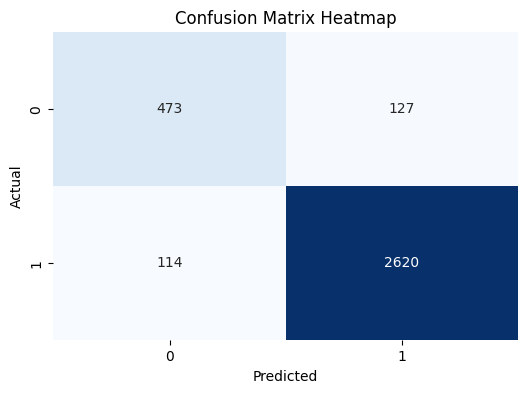

In [33]:
# 混同行列の作成
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 混同行列を作成
cm = confusion_matrix(valid_dataset["label"], valid_pred.argmax(axis=1))

# Seabornでヒートマップをプロット
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=[0, 1],
    yticklabels=[0, 1],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# CVの計算

In [34]:
from sklearn.metrics import accuracy_score

accuracy_score(valid_dataset["label"], valid_pred.argmax(axis=1))

0.9277144571085782

In [35]:
cv_score = roc_auc_score(valid_dataset["label"], valid_pred[:, 1])
print(f"CV Score: {cv_score}")

CV Score: 0.9666849548890515


In [36]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# テストに対する計算

In [37]:
test_dataset = test_dataset.map(
    tokenize,
    batched=False,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


# test_pred = softmax(trainer.predict(test_dataset).predictions, axis=-1)
test_pred = softmax(trainer.predict(CustomDataset(test_dataset)).predictions, axis=-1)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Map (num_proc=8):   0%|          | 0/11155 [00:00<?, ? examples/s]

# 提出ファイルの作成

In [38]:
sample_submission = pl.read_csv(f"{DATA_PATH}/sample_submission.csv")

if DEBUG:
    sample_submission = sample_submission.head(100)

(
    sample_submission.with_columns(
        pl.Series(test_pred[:, 1]).alias("target")
    ).write_csv(f"{MODEL_OUTPUT_PATH}/submission_{EXP_NAME}_cv{cv_score:.4f}.csv")
)

# AWSへのアップロード

In [39]:
# S3へのアップロード
# if not DEBUG and UPLOAD_DATA_TO_S3:
if UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://{COMPETITION_NAME}/trained_model/{output_name}"
    )

rm: cannot remove '/usr/bin/aws': No such file or directory
rm: cannot remove '/usr/bin/aws_completer': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58.0M  100 58.0M    0     0  60.1M      0 --:--:-- --:--:-- --:--:-- 59.1M0 --:--:-- --:--:-- --:--:-- 60.1M
You can now run: /usr/local/bin/aws --version
upload: ../trained_models/e027-add-word-cnt/added_tokens.json to s3://atmacup17/trained_model/e027-add-word-cnt/added_tokens.json
upload: ../trained_models/e027-add-word-cnt/checkpoint-189/added_tokens.json to s3://atmacup17/trained_model/e027-add-word-cnt/checkpoint-189/added_tokens.json
upload: ../trained_models/e027-add-word-cnt/checkpoint-189/config.json to s3://atmacup17/trained_model/e027-add-word-cnt/checkpoint-189/config.json
upload: ../trained_models/e027-add-word-cnt/checkpoint-189/scheduler.pt to s3://atmacup17/trained_model/e027-add-wo

In [40]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

In [41]:
if WANDB:
    wandb.finish()

eval/loss,█▃▂▂▂▁▁▁▁
eval/roc_auc,▁▇▇▇█████
eval/runtime,▂▁▁▁▁▄█▄▂
eval/samples_per_second,▇████▅▁▅▇
eval/steps_per_second,▇████▅▁▅▇
test/eval_roc_auc,█▁
test/loss,▁█
test/runtime,▁█
test/samples_per_second,▁█
test/steps_per_second,▁█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [42]:
print("finish Notebook!")

finish Notebook!
